In [1]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [2]:
target_gu = '중랑구'
target_dong = '신내동'
#target_purpose = '준주거'
target_building_age = 5
target_period = 60 # in months

In [3]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [4]:
date_today_record = str(date_today).split(' ')[0].replace('-', '')
date_today_record

'20210621'

In [5]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [6]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [7]:
def data_prep(bdtype, tradetype):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    
    basedir = './국토교통부_실거래가_공개시스템/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])

        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['시군구', '번지', '본번', '부번', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    if '건물명' in concat_df.columns:
        concat_df.rename(columns={'건물명':'건물(단지)명'}, inplace=True)
    elif '단지명' in concat_df.columns:
        concat_df.rename(columns={'단지명':'건물(단지)명'}, inplace=True)
    
    concat_df = concat_df[concat_df['층'] >= 0].reset_index(drop=True)
    
    return concat_df

In [8]:
yunrip_df = data_prep('연립다세대', '매매')
yunrip_df['부동산유형'] = '연립다세대'
print(yunrip_df.shape)
yunrip_df.head()

16it [00:01, 10.54it/s]


(642841, 14)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,해제사유발생일,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 171-13,선릉로14길 11,(171-13),68.08,56.10,56500,2,1988.0,NaN,18.0,2006-12-20,829.905993,33.0,연립다세대
1,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,40500,2,1988.0,NaN,18.0,2006-12-09,770.108386,33.0,연립다세대
2,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,42000,1,1988.0,NaN,18.0,2006-12-19,798.630918,33.0,연립다세대
3,서울특별시 강남구 개포동 1239-6,개포로15길 27,강남빌라 나동,52.75,44.68,22000,2,1988.0,NaN,18.0,2006-11-02,417.061611,33.0,연립다세대
4,서울특별시 강남구 개포동 1175-2,논현로6길 36-8,강남파크,49.43,23.70,17000,4,1993.0,NaN,13.0,2006-07-19,343.920696,28.0,연립다세대


In [9]:
officetel_df = data_prep('오피스텔', '매매')
officetel_df['부동산유형'] = '오피스텔'
print(officetel_df.shape)
officetel_df.head()

16it [00:00, 35.55it/s]


(182549, 13)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,해제사유발생일,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,6400,8,1997.0,NaN,9.0,2006-01-10,197.287300,24.0,오피스텔
1,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7100,7,1997.0,NaN,9.0,2006-01-10,218.865598,24.0,오피스텔
2,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7300,11,1997.0,NaN,9.0,2006-01-11,225.030826,24.0,오피스텔
3,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,31.91,7500,10,1997.0,NaN,9.0,2006-01-18,235.036039,24.0,오피스텔
4,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7400,15,1997.0,NaN,9.0,2006-01-19,228.113440,24.0,오피스텔


In [10]:
yunrip_df = yunrip_df.drop(columns=['대지권면적(㎡)'])
house_df = pd.concat([yunrip_df, officetel_df]).sort_values(['지번주소', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
print(house_df.shape)
house_df.head()

(825390, 13)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,해제사유발생일,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 1164-0,논현로2길 6,골드캐슬,58.05,57500,2,2017.0,NaN,1.0,2018-01-20,990.525409,4.0,연립다세대
1,서울특별시 강남구 개포동 1164-0,논현로2길 6,골드캐슬,58.05,57000,1,2017.0,NaN,1.0,2018-06-01,981.912145,4.0,연립다세대
2,서울특별시 강남구 개포동 1164-0,논현로2길 6,골드캐슬,58.05,63000,2,2017.0,NaN,2.0,2019-01-19,1085.271318,4.0,연립다세대
3,서울특별시 강남구 개포동 1164-26,논현로2길 64,슈베르트빌,34.47,31000,4,2015.0,NaN,1.0,2016-03-01,899.332753,6.0,연립다세대
4,서울특별시 강남구 개포동 1164-26,논현로2길 64,슈베르트빌,34.47,30000,3,2015.0,NaN,1.0,2016-03-20,870.322019,6.0,연립다세대


In [11]:
'''land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')
print(land_specs_df.shape)
land_specs_df.head()'''

"land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')\nprint(land_specs_df.shape)\nland_specs_df.head()"

In [12]:
'''last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)
print(last_df.shape)
last_df.head()'''

"last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)\nprint(last_df.shape)\nlast_df.head()"

In [13]:
'''house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)
print(house_merge_df.shape)'''

"house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)\nprint(house_merge_df.shape)"

In [14]:
house_df['구'] = house_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_df['동'] = house_df['지번주소'].apply(lambda x: x.split(' ')[2])
#house_merge_df['구'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[1])
#house_merge_df['동'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [15]:
target_df = house_df[
    (house_df['구'] == target_gu)
    &(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df.shape)
target_df.head()

(65, 15)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,해제사유발생일,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동
820370,서울특별시 중랑구 신내동 329-6,용마산로139가길 9,포시즌파크빌,38.75,22000,3,2016.0,NaN,3.0,2019-01-15,567.741935,5.0,연립다세대,중랑구,신내동
820371,서울특별시 중랑구 신내동 329-6,용마산로139가길 9,포시즌파크빌,38.75,22000,3,2016.0,NaN,3.0,2019-01-30,567.741935,5.0,연립다세대,중랑구,신내동
820372,서울특별시 중랑구 신내동 329-6,용마산로139가길 9,포시즌파크빌,38.75,24300,3,2016.0,NaN,3.0,2019-09-09,627.096774,5.0,연립다세대,중랑구,신내동
820373,서울특별시 중랑구 신내동 329-6,용마산로139가길 9,포시즌파크빌,39.03,22500,5,2016.0,NaN,3.0,2019-08-13,576.479631,5.0,연립다세대,중랑구,신내동
820374,서울특별시 중랑구 신내동 329-6,용마산로139가길 9,포시즌파크빌,39.33,22800,2,2016.0,NaN,3.0,2019-07-25,579.710145,5.0,연립다세대,중랑구,신내동


In [16]:
sales_idx_basedir = './한국부동산원/실거래가격지수/'
filenames = [f for f in os.listdir(sales_idx_basedir) if '연립다세대' in f]

sales_idx_df = pd.read_excel(sales_idx_basedir + filenames[0], header=[10, 11])

sales_idx_cols_list = []
for i in range(sales_idx_df.shape[1]):
    if i == 0:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0])
    else:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0] + '_' + sales_idx_df.columns[i][1])

sales_idx_df.columns = sales_idx_cols_list

In [17]:
def get_sales_idx(x):
    # x is a pandas timestamp
    
    df = sales_idx_df.copy()
    
    if pd.isna(x) == True:
        return x
    else:
        year = str(x.year)
        month = str(x.month)
        if len(month) == 1:
            month = '0'+month
        
        idx = df[year+'년 '+month+'월_지수'].iloc[0]
        
        return idx

In [18]:
def get_index_applied_prices(df):
    df = df.copy()
    
    last_idx = sales_idx_df.iloc[0,-2]
    
    last_date = sales_idx_df.columns[-1].split('_')[0]
    
    last_date = last_date.split(' ')[0].replace('년','') + '-' + last_date.split(' ')[1].replace('월','') + '-01'
    
    target_upper_limit_df = df[df['계약날짜'] < pd.to_datetime(last_date)]
    target_upper_limit_df['계약날짜_실거래지수'] = target_upper_limit_df['계약날짜'].apply(get_sales_idx)
    target_upper_limit_df['지수적용단가'] = target_upper_limit_df['단가(만원/㎡)'] / target_upper_limit_df['계약날짜_실거래지수'] * last_idx
    df['지수적용단가'] = df['단가(만원/㎡)']
    df.loc[target_upper_limit_df.index, '지수적용단가'] = target_upper_limit_df['지수적용단가']
    df['평가날짜'] = df['계약날짜']
    df.loc[target_upper_limit_df.index, '평가날짜'] = pd.to_datetime(last_date[:-2] + '01')
    
    return df

In [19]:
target_df = get_index_applied_prices(target_df)
print(target_df.shape)
target_df.head()

(65, 17)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,해제사유발생일,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,지수적용단가,평가날짜
820370,서울특별시 중랑구 신내동 329-6,용마산로139가길 9,포시즌파크빌,38.75,22000,3,2016.0,NaN,3.0,2019-01-15,567.741935,5.0,연립다세대,중랑구,신내동,691.367288,2021-04-01
820371,서울특별시 중랑구 신내동 329-6,용마산로139가길 9,포시즌파크빌,38.75,22000,3,2016.0,NaN,3.0,2019-01-30,567.741935,5.0,연립다세대,중랑구,신내동,691.367288,2021-04-01
820372,서울특별시 중랑구 신내동 329-6,용마산로139가길 9,포시즌파크빌,38.75,24300,3,2016.0,NaN,3.0,2019-09-09,627.096774,5.0,연립다세대,중랑구,신내동,735.754564,2021-04-01
820373,서울특별시 중랑구 신내동 329-6,용마산로139가길 9,포시즌파크빌,39.03,22500,5,2016.0,NaN,3.0,2019-08-13,576.479631,5.0,연립다세대,중랑구,신내동,678.176485,2021-04-01
820374,서울특별시 중랑구 신내동 329-6,용마산로139가길 9,포시즌파크빌,39.33,22800,2,2016.0,NaN,3.0,2019-07-25,579.710145,5.0,연립다세대,중랑구,신내동,683.736541,2021-04-01


In [20]:
target_df = target_df.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df1 = target_df[['지번주소', '건물(단지)명', '건물연식', '층', '전용면적(㎡)', '계약날짜', '거래금액(만원)', '단가(만원/㎡)', '평가날짜', '지수적용단가', '부동산유형']]
target_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/실거래가.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [21]:
target_df1.head()

,지번주소,건물(단지)명,건물연식,층,전용면적(㎡),계약날짜,거래금액(만원),단가(만원/㎡),평가날짜,지수적용단가,부동산유형
0,서울특별시 중랑구 신내동 329-6,포시즌파크빌,5.0,3,41.83,2017-07-17,21000,502.032034,2021-04-01,637.571954,연립다세대
1,서울특별시 중랑구 신내동 329-6,포시즌파크빌,5.0,2,42.56,2017-11-05,22900,538.063910,2021-04-01,683.755475,연립다세대
2,서울특별시 중랑구 신내동 329-6,포시즌파크빌,5.0,3,38.75,2019-01-15,22000,567.741935,2021-04-01,691.367288,연립다세대
3,서울특별시 중랑구 신내동 329-6,포시즌파크빌,5.0,3,38.75,2019-01-30,22000,567.741935,2021-04-01,691.367288,연립다세대
4,서울특별시 중랑구 신내동 329-6,포시즌파크빌,5.0,2,39.52,2019-05-11,24000,607.287449,2021-04-01,728.700212,연립다세대


In [22]:
target_df1_30 = target_df1[
    (target_df1['전용면적(㎡)'] >= 28)
    &(target_df1['전용면적(㎡)'] <= 32)
]

In [23]:
target_df1_30.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/실거래가_30.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

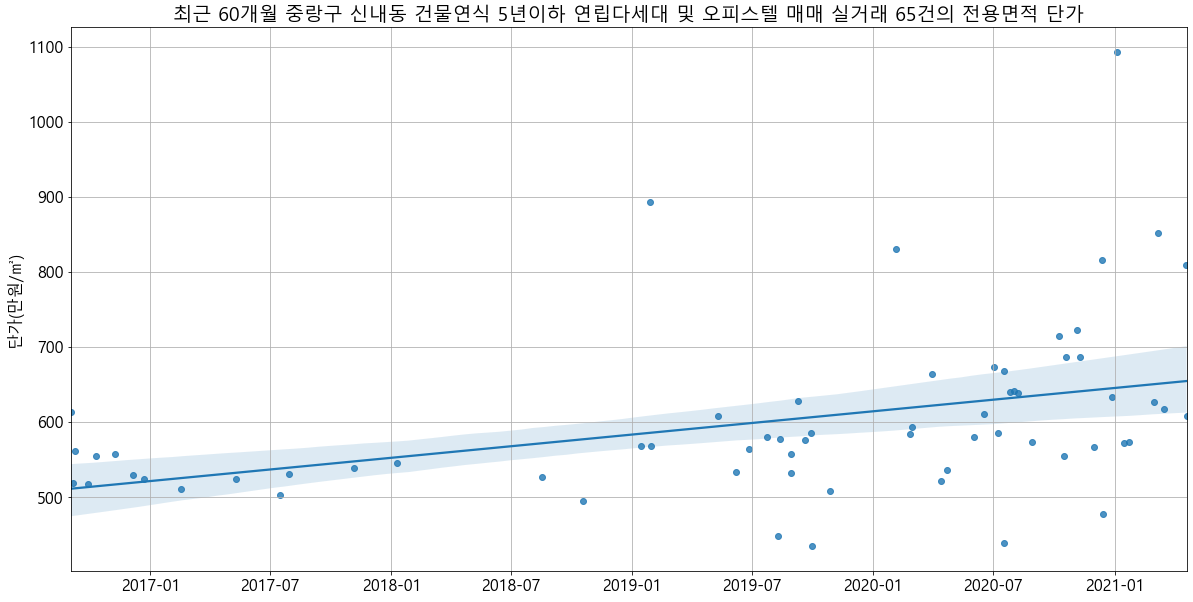

In [24]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/산포도.png'.format(target_gu, target_dong, date_today_record))

In [25]:
target_last_df = target_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last').reset_index(drop=True)

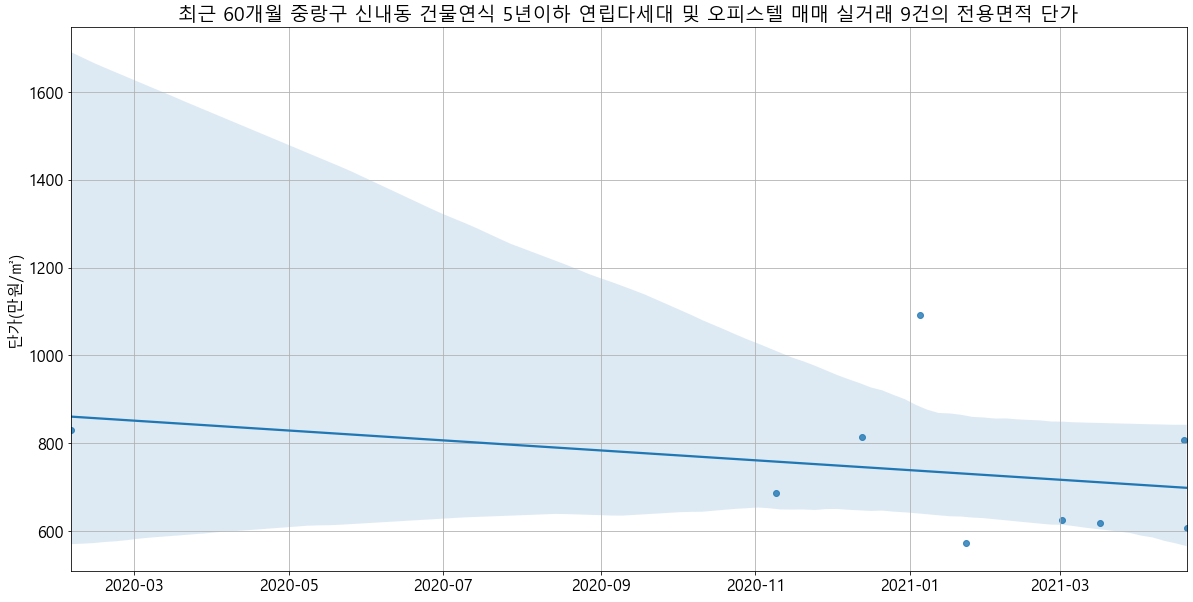

In [26]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_last_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_last_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_last_df['계약날짜']), y=target_last_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/마지막_산포도.png'.format(target_gu, target_dong, date_today_record))

In [27]:
target_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/마지막_실거래가.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [28]:
target_df2 = house_df[
    (house_df['구'] == target_gu)
    &(house_df['동'] == target_dong)
    #&(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_df['계약날짜기준_건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df2.shape)
target_df2.head()

(1298, 15)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,해제사유발생일,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동
820363,서울특별시 중랑구 신내동 281-1,용마산로139다길 25,블랑쉬에,23.12,11000,1,2014.0,NaN,6.0,2020-06-23,475.778547,7.0,연립다세대,중랑구,신내동
820364,서울특별시 중랑구 신내동 281-1,용마산로139다길 25,블랑쉬에,24.79,9500,1,2014.0,NaN,6.0,2020-06-04,383.219040,7.0,연립다세대,중랑구,신내동
820365,서울특별시 중랑구 신내동 281-1,용마산로139다길 25,블랑쉬에,26.59,11000,4,2014.0,NaN,6.0,2020-06-10,413.689357,7.0,연립다세대,중랑구,신내동
820366,서울특별시 중랑구 신내동 281-1,용마산로139다길 25,블랑쉬에,29.88,14000,2,2014.0,NaN,5.0,2019-10-24,468.540830,7.0,연립다세대,중랑구,신내동
820367,서울특별시 중랑구 신내동 281-1,용마산로139다길 25,블랑쉬에,37.51,16000,1,2014.0,NaN,5.0,2019-10-25,426.552919,7.0,연립다세대,중랑구,신내동


In [29]:
target_df2 = get_index_applied_prices(target_df2)

<AxesSubplot:title={'center':'중랑구 신내동 계약날짜기준 건물연식 5년이하 연립다세대 및 오피스텔 매매 실거래 1298건의 전용면적 단가'}, xlabel='단가(만원/㎡)', ylabel='Count'>

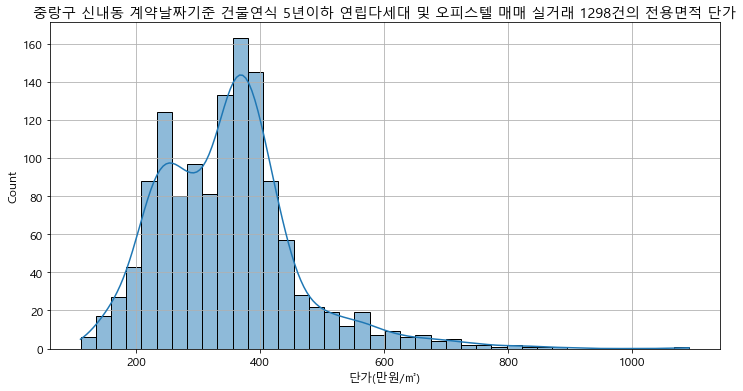

In [30]:
font = {'size': 12}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(12,6))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 {}건의 전용면적 단가'.format(target_gu, target_dong, target_building_age, target_df2.shape[0]))
plt.grid(True)
sns.histplot(target_df2['단가(만원/㎡)'], kde=True)

In [31]:
target_df3 = target_df2[['지번주소', '건물(단지)명', '건축년도', '층', '전용면적(㎡)', '계약날짜', '단가(만원/㎡)', '평가날짜', '지수적용단가', '부동산유형']]
target_df3 = target_df3.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df3.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/지수적용_실거래가.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [32]:
target_df3_30 = target_df3[
    (target_df3['전용면적(㎡)'] >= 28)
    &(target_df3['전용면적(㎡)'] <= 32)
]

In [33]:
target_df3_30.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/지수적용_실거래가_30.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [34]:
concat_df = pd.concat([target_df2])

In [35]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
concat_df = concat_df.drop_duplicates(['지번주소', '건축년도', '전용면적(㎡)'], keep='last').reset_index(drop=True)

In [36]:
concat_df['단가평균'] = concat_df[['지번주소', '건축년도', '단가(만원/㎡)']].groupby(['지번주소', '건축년도']).transform('mean')['단가(만원/㎡)']
concat_df['지수적용단가평균'] = concat_df[['지번주소', '건축년도', '지수적용단가']].groupby(['지번주소', '건축년도']).transform('mean')['지수적용단가']

In [37]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '평가날짜']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

(236, 19)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,해제사유발생일,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
0,서울특별시 중랑구 신내동 281-1,용마산로139다길 25,블랑쉬에,23.12,11000,1,2014.0,NaN,6.0,2020-06-23,475.778547,7.0,연립다세대,중랑구,신내동,525.067829,2021-04-01,433.556139,486.346808
1,서울특별시 중랑구 신내동 281-1,용마산로139다길 25,블랑쉬에,24.79,9500,1,2014.0,NaN,6.0,2020-06-04,383.219040,7.0,연립다세대,중랑구,신내동,422.919425,2021-04-01,433.556139,486.346808
2,서울특별시 중랑구 신내동 281-1,용마산로139다길 25,블랑쉬에,26.59,11000,4,2014.0,NaN,6.0,2020-06-10,413.689357,7.0,연립다세대,중랑구,신내동,456.546379,2021-04-01,433.556139,486.346808
3,서울특별시 중랑구 신내동 281-1,용마산로139다길 25,블랑쉬에,29.88,14000,2,2014.0,NaN,5.0,2019-10-24,468.540830,7.0,연립다세대,중랑구,신내동,543.369166,2021-04-01,433.556139,486.346808
4,서울특별시 중랑구 신내동 281-1,용마산로139다길 25,블랑쉬에,37.51,16000,3,2014.0,NaN,6.0,2020-05-27,426.552919,7.0,연립다세대,중랑구,신내동,483.831240,2021-04-01,433.556139,486.346808


In [38]:
concat_last_df = concat_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last')
print(concat_last_df.shape)
concat_last_df

(62, 19)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,해제사유발생일,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
4,서울특별시 중랑구 신내동 281-1,용마산로139다길 25,블랑쉬에,37.510,16000,3,2014.0,NaN,6.0,2020-05-27,426.552919,7.0,연립다세대,중랑구,신내동,483.831240,2021-04-01,433.556139,486.346808
14,서울특별시 중랑구 신내동 329-6,용마산로139가길 9,포시즌파크빌,39.520,24000,3,2016.0,NaN,5.0,2021-04-20,607.287449,5.0,연립다세대,중랑구,신내동,607.287449,2021-04-20,563.708590,645.117584
17,서울특별시 중랑구 신내동 382-6,봉화산로 240,스마트빌,52.360,30000,2,2016.0,NaN,5.0,2021-01-23,572.956455,5.0,연립다세대,중랑구,신내동,587.913726,2021-04-01,544.960014,613.078138
23,서울특별시 중랑구 신내동 391-4,용마산로129나길 3,청기와타운,78.930,24000,3,1997.0,NaN,23.0,2020-01-17,304.066895,24.0,연립다세대,중랑구,신내동,351.530752,2021-04-01,296.020527,381.372769
27,서울특별시 중랑구 신내동 393-18,봉화산로 233-9,"남양아트빌(1,2,3동)",139.920,24300,4,2010.0,NaN,5.0,2015-10-05,173.670669,11.0,연립다세대,중랑구,신내동,241.220968,2021-04-01,345.193023,376.364821
32,서울특별시 중랑구 신내동 410-2,봉화산로54가길 4,대성빌라,46.980,24500,3,1991.0,NaN,30.0,2021-05-21,521.498510,30.0,연립다세대,중랑구,신내동,521.498510,2021-05-21,369.089146,420.573865
35,서울특별시 중랑구 신내동 410-21,봉화산로54길 27-5,수혜빌라,80.110,23000,2,1996.0,NaN,24.0,2020-10-20,287.105230,25.0,연립다세대,중랑구,신내동,307.227305,2021-04-01,264.933385,286.789288
42,서울특별시 중랑구 신내동 410-52,용마산로129길 44,국일빌라,82.570,16500,4,1999.0,NaN,8.0,2007-07-04,199.830447,22.0,연립다세대,중랑구,신내동,336.048669,2021-04-01,295.653410,392.334139
44,서울특별시 중랑구 신내동 410-53,봉화산로56길 40,신일빌라,45.270,28000,1,1989.0,NaN,32.0,2021-04-24,618.511155,32.0,연립다세대,중랑구,신내동,618.511155,2021-04-24,536.911564,577.072389
47,서울특별시 중랑구 신내동 410-59,용마산로129나길 28,이화빌라(A동),64.350,15000,1,1991.0,NaN,17.0,2008-04-19,233.100233,30.0,연립다세대,중랑구,신내동,313.330918,2021-04-01,272.726152,374.276155


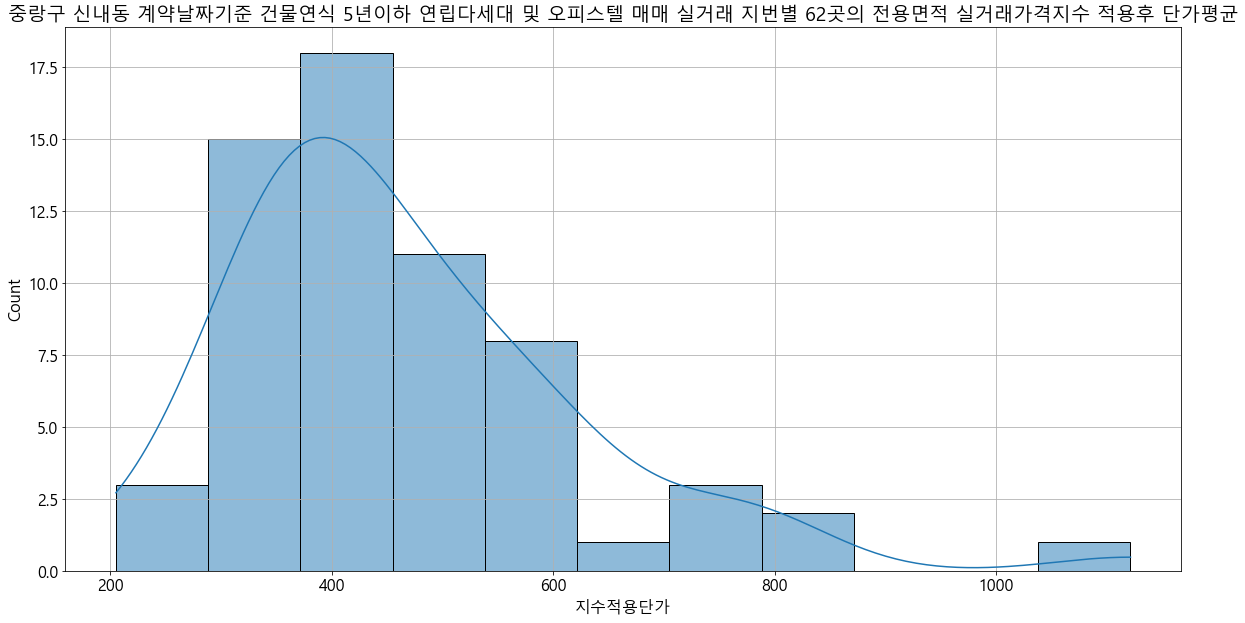

In [39]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 지번별 {}곳의 전용면적 실거래가격지수 적용후 단가평균'.format(target_gu, target_dong, target_building_age, concat_last_df.shape[0]))
plt.grid(True)
sns.histplot(concat_last_df['지수적용단가'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/지번별_분포도.png'.format(target_gu, target_dong, date_today_record))

In [40]:
concat_last_df = concat_last_df.sort_values(['지번주소']).reset_index(drop=True)

In [41]:
concat_last_df = concat_last_df[['지번주소', '건물(단지)명', '건축년도', '전용면적(㎡)', '층', '계약날짜', '단가(만원/㎡)', '평가날짜', '지수적용단가', '부동산유형']]
concat_last_df.rename(columns={'계약날짜':'마지막_계약날짜'}, inplace=True)
concat_last_df.head()

,지번주소,건물(단지)명,건축년도,전용면적(㎡),층,마지막_계약날짜,단가(만원/㎡),평가날짜,지수적용단가,부동산유형
0,서울특별시 중랑구 신내동 281-1,블랑쉬에,2014.0,37.51,3,2020-05-27,426.552919,2021-04-01,483.831240,연립다세대
1,서울특별시 중랑구 신내동 329-6,포시즌파크빌,2016.0,39.52,3,2021-04-20,607.287449,2021-04-20,607.287449,연립다세대
2,서울특별시 중랑구 신내동 382-6,스마트빌,2016.0,52.36,2,2021-01-23,572.956455,2021-04-01,587.913726,연립다세대
3,서울특별시 중랑구 신내동 391-4,청기와타운,1997.0,78.93,3,2020-01-17,304.066895,2021-04-01,351.530752,연립다세대
4,서울특별시 중랑구 신내동 393-18,"남양아트빌(1,2,3동)",2010.0,139.92,4,2015-10-05,173.670669,2021-04-01,241.220968,연립다세대


In [42]:
concat_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/지수적용_마지막_실거래가.xlsx'.format(target_gu, target_dong, date_today_record), index=False)